# HF Casual Language Model Benchmark with Module Injection

Highlights:
- Singe instance multiple GPUs with DeepSpeed ZeRO-3.
- Inject modules during model initialization.


In this benchmark, we benchmark the effectiveness of PyTorch custom modules using HuggingFace CLM (e.g., GPT) models on a NVIDIA V100 GPU. The efficient PyTorch custom modules are injected to HF models automatically with EPOI provided injection policies.

## Setup

In [1]:
from IPython.display import clear_output
import os
import torch

# Install dependencies
!pip install datasets evaluate accelerate deepspeed psutil pybind11 huggingface_hub

clear_output()

In [2]:
try:
    import apex
except ImportError:
    print("Installing apex")
    !git clone https://github.com/NVIDIA/apex.git || true
    clear_output()

    !cd apex; pip3 install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

In [3]:
!git clone https://github.com/huggingface/transformers || true
!cd transformers; git reset origin/main --hard; git checkout 2bdd9fa28411a2822cd1395ed78abeef4a69ec6f
clear_output()

# Note that this patch is generated with transformers commit
# 801ebd045d4310fef2e837713fa630cb183f0104 @ Mon Sep 19 16:55:50 2022 -0400
with open("transformers/benchmark.patch", "w") as f:
    f.write('''
diff --git a/src/transformers/trainer.py b/src/transformers/trainer.py
index c1869ef76..06d33d24b 100755
--- a/src/transformers/trainer.py
+++ b/src/transformers/trainer.py
@@ -1712,7 +1712,9 @@ class Trainer:
                 self._load_rng_state(resume_from_checkpoint)

             step = -1
+            step_metrics = {"step_time_list": []}
             for step, inputs in enumerate(epoch_iterator):
+                step_start = time.time()

                 # Skip past any already trained steps if resuming training
                 if steps_trained_in_current_epoch > 0:
@@ -1819,6 +1821,7 @@ class Trainer:
                 else:
                     self.control = self.callback_handler.on_substep_end(args, self.state, self.control)

+                step_metrics["step_time_list"].append(time.time() - step_start)
                 if self.control.should_epoch_stop or self.control.should_training_stop:
                     break
             if step < 0:
@@ -1865,6 +1868,7 @@ class Trainer:
         train_loss = self._total_loss_scalar / self.state.global_step

         metrics = speed_metrics("train", start_time, num_samples=num_train_samples, num_steps=self.state.max_steps)
+        metrics.update(step_metrics)
         self.store_flos()
         metrics["total_flos"] = self.state.total_flos
         metrics["train_loss"] = train_loss
diff --git a/src/transformers/trainer_pt_utils.py b/src/transformers/trainer_pt_utils.py
index 7ff0eb51a..ea5134e5a 100644
--- a/src/transformers/trainer_pt_utils.py
+++ b/src/transformers/trainer_pt_utils.py
@@ -867,6 +867,8 @@ def metrics_format(self, metrics: Dict[str, float]) -> Dict[str, float]:
             metrics_copy[k] = f"{ int(v) >> 30 }GF"
         elif type(metrics_copy[k]) == float:
             metrics_copy[k] = round(v, 4)
+        elif "_list" in k:
+            metrics_copy[k] = f"{','.join(str(round(e, 4)) for e in v)}"

     return metrics_copy

''')

!cd transformers; git apply benchmark.patch; rm benchmark.patch; git status

# Install the changed transformers without checking dependencies (otherwise it may ruin your PyTorch setting...)
#!cd transformers; pip install -e ".[dev]" --no-deps

HEAD detached from 12ce2941c
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   src/transformers/trainer.py
	modified:   src/transformers/trainer_pt_utils.py

no changes added to commit (use "git add" and/or "git commit -a")


In [4]:
# Set benchmark configurations
# Tested models: gpt2-xx (e.g., medium, xl)
#                EleutherAI/gpt-neo-xx (e.g, 1.3B, 2.7B)
#                EleutherAI/gpt-j-6B
model_name = "gpt2-large"
n_gpu = 8

# Whether to dump all plotted figures to PDF files.
dump_fig_to_pdf = False

# Single device configuration.
exp_kwargs = {
    "gpus": ",".join([str(i) for i in range(n_gpu)]),
    "seq_len": 1024,
    "fp16": True,
    "optim": "adamw_apex_fused",
    "kwargs": {"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}
}

if n_gpu > 1:
    # Multiple devices. Use DeepSpeed with ZeRO-3.
    # Note that HF Trainer will re-built DeepSpeed config to reflect its configs,
    # so we only need to specify a default DeepSpeed config file here along with other configs.
    # However, optimizer (i.e., adamw_apex_fused) and AMP backend will be overwritten.
    exp_kwargs["deepspeed"] = True
    exp_kwargs["ds_config"] = "./transformers/tests/deepspeed/ds_config_zero3.json"
    

# Log environments
print(f'Model               :', model_name)
print(f'Pytorch version     :', torch.__version__)
print(f'PyTorch CUDA version:', torch.version.cuda)
print(f'Used GPU:')
for i in range(torch.cuda.device_count()):
    print(f'GPU{i}\t:',torch.cuda.get_device_name(i))
    if i + 1 == n_gpu:
        break

print('\nBenchmark configuration:')
print(f'{"dump-to-file":14s}: {dump_fig_to_pdf}')
for key, val in exp_kwargs.items():
    print(f'{key:14s}: {val}')

Model               : gpt2-large
Pytorch version     : 1.13.0+cu117
PyTorch CUDA version: 11.7
Used GPU:
GPU0	: Tesla V100-SXM2-16GB
GPU1	: Tesla V100-SXM2-16GB
GPU2	: Tesla V100-SXM2-16GB
GPU3	: Tesla V100-SXM2-16GB
GPU4	: Tesla V100-SXM2-16GB
GPU5	: Tesla V100-SXM2-16GB
GPU6	: Tesla V100-SXM2-16GB
GPU7	: Tesla V100-SXM2-16GB

Benchmark configuration:
dump-to-file  : False
gpus          : 0,1,2,3,4,5,6,7
seq_len       : 1024
fp16          : True
optim         : adamw_apex_fused
kwargs        : {'flags': ['--half_precision_backend=apex', '--fp16_opt_level=O2']}
deepspeed     : True
ds_config     : ./transformers/tests/deepspeed/ds_config_zero3.json


## Benchmark Scripts

In [5]:
import os
import re
import json

import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from transformers import AutoConfig, PretrainedConfig

@dataclass
class Exp:
    name: str           # Experiment name
    model: str          # huggingface model name
    batch_size: int     # batch size per GPU
    seq_len: int = None # input sequence length
        
    ## Improve speed / reduce memory  
    bf16: bool = False  # Faster, less memory. Recommend if GPU supports
    fp16: bool = False  # Faster, less memory, but need to scale loos. 
                        # Recommend if BF16 is not available.
    optim: str = 'adamw_hf'  # Optimization method
    grad_ckpt: bool = False  # save memory with an extra forward
    grad_accum: int = 1      # accumulate gradients for better performance
    steps: int = 20          # number of parameter updates
        
    ## Multi-GPUs
    gpus: str = '0'          # GPUs to use. "0,1" means use GPU 0 and 1
    tensor_para: int = 1     # Tensor parallelism
    deepspeed: bool = False  # if or not use deepspeed
    ds_config: str = ''      # deepspeed config
        
    ## kwargs
    kwargs: dict = None
        
    def __post_init__(self):         
        model_conf = AutoConfig.from_pretrained(self.model)
        get = lambda *keys: max([getattr(model_conf, k) if hasattr(model_conf, k) else 0 for k in keys])
        self.num_layers = get('num_hidden_layers', 'n_layer')
        self.num_gpus = len(self.gpus.split(','))                      
        self.hidden_size = get('hidden_size', 'n_embd', 'd_model')
        self.vocab_size = get('vocab_size')
        self.num_heads = get('num_attention_heads', 'n_head')
        if self.seq_len is None:
            self.seq_len = get('max_position_embeddings', 'n_ctx')
        n, h, s, v = self.num_layers, self.hidden_size, self.seq_len, self.vocab_size
        att, ffn, embed = 4*h*s**2 + 8*s*h**2, 16*s*h**2, 2*s*h*v
        forward = n*(att+ffn) + embed
        # TFLOPs to train one example
        self.tflops = (4 * forward if self.grad_ckpt else 3 * forward) / 1e12
        if self.deepspeed:            
            self.launcher = 'deepspeed'            
        else:
            self.launcher = f'torchrun --nproc_per_node {self.num_gpus}' 
            
    def print_results(self):
        print('Total samples / second\t: %.1f' % self.samples_per_sec)
        print('Per GPU memory (GB)\t: %.1f'% self.gpu_mem)
        print('Per GPU TFLOPs\t\t: %.1f' % (self.samples_per_sec * self.tflops / self.num_gpus))

In [6]:
%config InlineBackend.figure_formats = ['svg']

def compare(exps, save_to=""):
    fig, ax = plt.subplots(ncols=3, figsize=(9,len(exps)/2))
    x = list(range(len(exps)))
    for i, (y, l) in enumerate((
        ([e.samples_per_sec for e in exps], 'Samples / sec'), 
        ([e.samples_per_sec * e.tflops / e.num_gpus for e in exps], 'per GPU TFLOPS'),
        ([e.gpu_mem for e in exps], 'per GPU memory (GB)'))):
        print(f"{l}: {['%.2f' % e for e in y]}")
        ax[i].barh(x, y, align='center', height=0.6, color=plt.get_cmap('Set1')(x))
        ax[i].invert_yaxis()
        ax[i].set_xlabel(l)
        if i == 0:
            ax[i].set_yticks(x, labels=[e.name for e in exps])
        else:
            ax[i].set_yticklabels([])

    if save_to:
        plt.savefig(save_to, bbox_inches="tight")
    else:
        plt.show()

In [7]:
def hf_gpt(exp):
    cmd = f'''export CUDA_VISIBLE_DEVICES={exp.gpus}; \
{exp.launcher} transformers/examples/pytorch/language-modeling/run_clm.py \
--config_name {exp.model} --tokenizer_name {exp.model} \
--dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 \
--do_train --per_device_train_batch_size {exp.batch_size} \
--block_size {exp.seq_len} --learning_rate 2e-5 \
--max_steps {exp.steps} --optim {exp.optim} \
--fp16 {exp.fp16} --bf16 {exp.bf16} \
--gradient_accumulation_steps {exp.grad_accum} \
--gradient_checkpointing {exp.grad_ckpt} \
--report_to none \
--output_dir /tmp/gpt/ --overwrite_output_dir yes --skip_memory_metrics False'''
    if exp.deepspeed:
        cmd += f' --deepspeed {exp.ds_config}'
    cmd += ' > log.txt 2>&1'
    os.system(cmd)
    ret = hf_log(exp, 'log.txt')
    if ret is not None:
        ret.print_results()
    return ret

    
def hf_log(exp, log_filename):
    import re
    with open(log_filename) as f:
        lines = f.readlines()
        
    global_batch_size = 0
    dedup = set()
    for l in lines:
        tokens = re.findall(r'(Apply .*? for .*? times)', l)
        l = l.replace("\n", "")
        for token in tokens:
            if token not in dedup:
                print(token)
                dedup.add(token)
        if 'CUDA out of memory' in l:
            print('Out of GPU memory, try a smaller batch size')
            return None
        if 'Total train batch size' in l:
            global_batch_size = int(next(iter(reversed(re.findall('= +([\d\.]+)', l))), 0))
        if '{\'train_runtime' in l:
            if global_batch_size == 0:
                print(f'Failed to parse global batch size. Check {log_filename} to find error')
            metrics = json.loads(l.replace('\'', '\"'))
            exp.gpu_mem = (metrics['init_mem_cpu_peaked_delta'] + \
                    metrics['train_mem_gpu_alloc_delta'] + metrics['train_mem_gpu_peaked_delta']) / 1e9
            if 'step_time_list' in metrics:
                step_time_list = metrics['step_time_list']
                # Remove the first 5 iterations (warmup)
                step_time_list = step_time_list[5:] if len(step_time_list) > 5 else step_time_list
                exp.samples_per_sec = (global_batch_size * len(step_time_list)) / sum(step_time_list)
            else:
                print("Cannot find 'step_time_list', use HF Triner reported samples/sec")
                exp.samples_per_sec = metrics['train_samples_per_second']
            return exp
    print(f'Failed. Check "{log_filename}" to find error')    
    return None

## Benchmark

In [8]:
v1 = hf_gpt(Exp('Vanilla(bs1)', model_name, 1, **exp_kwargs))

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Total samples / second	: 1.3
Per GPU memory (GB)	: 8.3
Per GPU TFLOPs		: 0.8


## Setup epoi and xFormers

In [9]:
def build_package(name, url):
    import importlib
    import os, sys
    if importlib.util.find_spec(name) is None:
        os.system(f"git clone {url} {name} || true")
        os.system(f"cd {name}; git submodule update --init --recursive")
        os.system(f"cd {name}; pip3 install -r requirements.txt || true")
        os.system(f'cd {name}; pip3 install -e ".[dev]"') 

build_package("xformers", "https://github.com/facebookresearch/xformers.git")
build_package("epoi", "https://github.com/comaniac/epoi.git")

## Module Injection
Now we inject efficient modules to HF GPT-2. There are some highlights:
1. The patch is applied to the training script instead of the model itself.
2. The current injection policies include (SelfAttention -> FlashAttention) and (MLP -> FuedMLP). FusedMLP fuses the bias and GELU to reduce memory footprint.
3. The InjectModuleContext can also be used with "with" statement:
```python
with InjectModuleContext():
    model = init_model(...)
```

In [10]:
with open("transformers/patch", "w") as f:
    f.write('''
diff --git a/examples/pytorch/language-modeling/run_clm.py b/examples/pytorch/language-modeling/run_clm.py
index c12005500..aeda64d62 100755
--- a/examples/pytorch/language-modeling/run_clm.py
+++ b/examples/pytorch/language-modeling/run_clm.py
@@ -373,6 +373,9 @@ def main():
             "You can do it from another script, save it, and load it from here, using --tokenizer_name."
         )

+    from epoi.inject import InjectModuleContext
+    ctx = InjectModuleContext()
+    ctx.__enter__()
     if model_args.model_name_or_path:
         model = AutoModelForCausalLM.from_pretrained(
             model_args.model_name_or_path,
@@ -386,6 +389,7 @@ def main():
         model = AutoModelForCausalLM.from_config(config)
         n_params = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters()).values())
         logger.info(f"Training new model from scratch - Total size={n_params/2**20:.2f}M params")
+    ctx.__exit__(None, None, None)

     # We resize the embeddings only when necessary to avoid index errors. If you are creating a model from scratch
     # on a small vocab and want a smaller embedding size, remove this test.

''')

!cd transformers; git apply patch; rm patch; git diff examples/pytorch/language-modeling/run_clm.py

diff --git a/examples/pytorch/language-modeling/run_clm.py b/examples/pytorch/language-modeling/run_clm.py
index c12005500..aeda64d62 100755
--- a/examples/pytorch/language-modeling/run_clm.py
+++ b/examples/pytorch/language-modeling/run_clm.py
@@ -373,6 +373,9 @@ def main():
             "You can do it from another script, save it, and load it from here, using --tokenizer_name."
         )
 
+    from epoi.inject import InjectModuleContext
+    ctx = InjectModuleContext()
+    ctx.__enter__()
     if model_args.model_name_or_path:
         model = AutoModelForCausalLM.from_pretrained(
             model_args.model_name_or_path,
@@ -386,6 +389,7 @@ def main():
         model = AutoModelForCausalLM.from_config(config)
         n_params = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters()).values())
         logger.info(f"Training new model from scratch - Total size={n_params/2**20:.2f}M params")
+    ctx.__exit__(None, None, None)
 
     # We resize the embeddings only when 

In [11]:
v2 = hf_gpt(Exp('Injected(bs1)', model_name, 1, **exp_kwargs))

Apply GenericSelfAttention for 36 times
Apply FusedMLP for 36 times
Total samples / second	: 1.4
Per GPU memory (GB)	: 5.6
Per GPU TFLOPs		: 0.9


In [12]:
v3 = hf_gpt(Exp('Injected(bs2)', model_name, 2, **exp_kwargs))

Apply GenericSelfAttention for 36 times
Apply FusedMLP for 36 times
Total samples / second	: 2.8
Per GPU memory (GB)	: 9.8
Per GPU TFLOPs		: 1.8


Samples / sec: ['1.27', '1.39', '2.76']
per GPU TFLOPS: ['0.85', '0.92', '1.84']
per GPU memory (GB): ['8.30', '5.61', '9.80']


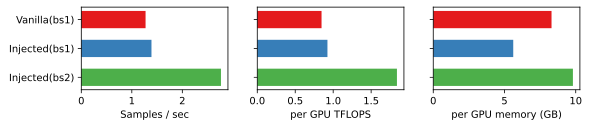

In [13]:
compare([v1, v2, v3], "inject_clm.pdf" if dump_fig_to_pdf else None)